# simple DNN

In [ ]:
 
import matplotlib.pyplot as plt
import numpy as np
import keras
import h5py

# get reproducible results
from numpy.random import seed
seed(0xdeadbeef)
from tensorflow import set_random_seed
set_random_seed(0xdeadbeef)

# needed to run on a mac: 
import os 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
datadir = '/home/hades/Videos/yelp'
h5 = h5py.File(datadir+'/data.h5')
d = h5['reviews']
d.shape

In [ ]:
h5.keys()

In [4]:
data=h5['reviews']

In [6]:
data.shape

(6685900, 254)

In [7]:
data[0]

array([    5,     1,     0,     0,   696,    26,    39,  3348,    26,
        1523,    44,   336,    64,    14,   153,  5179,  2731,    24,
          72,   172,  4377,   125,   257,  3044,  6568, 10127,  8410,
           3,    33,   277,   219,   501,  8900,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

We can decode this review with the vocabulary:

In [ ]:
# load the vocabulary object from index.pck
import pickle 
with open(datadir+'/'+'index.pck', 'rb') as pckf: 
    vocab = pickle.load(pckf)
# selecting the text of the first review,
# excluding the first 4 slots
first_review = data[0,4:]
# the decoding returns a list of words, 
# and we join the words with spaces
' '.join( vocab.decode(first_review) )

Let's extract the information needed to train our neural networks.

In [ ]:
# the reviews
x = data[:, 4:]
# the stars, from which we will
# obtain the labels (see below)
stars = data[:,0]
# additional features we might consider:
useful = data[:,1]
cool = data[:,2]
funny = data[:,3]

Let's check the distribution of stars:

(array([  0., 137.,  81., 108., 238., 436.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Patch objects>)

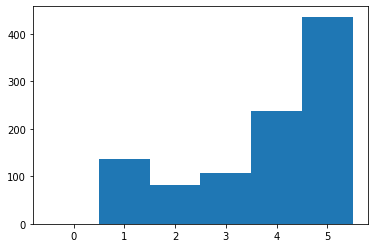

In [29]:
plt.hist(stars[:1000], range=(-0.5, 5.5), bins=6)

Now we want to split the dataset in two categories that have roughly the same number of examples.

I prefer to define as positive all reviews with 4 stars or more. Technically, here is how to define the targets:

In [ ]:
# first fill an array with zeros, 
# with the same shape as stars
y = np.zeros_like(stars)
# then write 1 if the number of stars is 4 or 5
y[stars>3.5] = 1
print(y, len(y))
print(stars, len(stars))

I will split the dataset into a training and a test sample. At first, we will use 20000 examples for the test sample, and "only" 100,000 examples for the training sample:

In [ ]:
n_test = 20000
n_train = 100000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:n_train+n_test]
y_train = y[n_test:n_train+n_test]

We start by creating an empty model:

In [ ]:
from keras.models import Sequential
model = Sequential()

In [ ]:
# the first layer is the embedding layer. 
# we indicate the number of possible words, 
# the dimension of the embedding space, 
# and the maximum size of the text. 
review_length = len(x_train[0])
model.add(keras.layers.Embedding(len(vocab.words), 2, 
                                 input_length=review_length))

Since the input to the layer has a rank greater than 2, then it is flattened before moving forward. This 2D array cannot be used directly as input to a dense layer, so we need to flatten it into a 1D array with 500 slots

In [ ]:
model.add(keras.layers.Flatten())

Now we add dropout regularization layer with 40% dropout of values from previous layer to reduce overfitting.

In [ ]:
model.add(keras.layers.Dropout(rate=0.4))

Now we add a dense layer, which will analyze the results of the embedding. we start with only 5 neurons. We will see later if performance can be improved by increasing the number of neurons.

In [ ]:
model.add(keras.layers.Dense(5))

And finally, we end with a dense layer consisting of a single neuron with a sigmoid activation function. 

In [ ]:
model.add(keras.layers.Dense(1, activation='sigmoid'))

 printing the full model. 1. Optimizer algo: Adam ; 2. loss function: cross-entropy (to maximize the likelihood of classifying the input data correctly) ' 3. accuracy function

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

So we end up with a validation accuracy of almost 90%. Since these values vary in almost increasing way when compared with the model accuracy, we can see our model is not overfitting much.

We will look further for the performance in detail

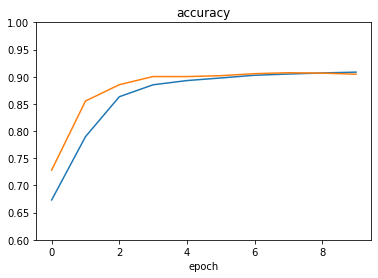

<Figure size 432x288 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
    '''Plot the training and validation accuracy'''
    acc = history.history['acc']
    test_acc = history.history['val_acc']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, test_acc)
    if miny:
        plt.ylim(miny, 1.0)
    plt.title('accuracy') 
    plt.xlabel('epoch')
    plt.figure()
    
plot_accuracy(history, miny=0.6)

The training accuracy plateaus at 90%, so training further will not help much as this network underfits the data.

We will try to modify the architecture to make it more complex so that we can improve training and test accuracies.

# Dense network: increased complexity 

After a few tuning trials, I ended up with the following architecture which is more ecomplex than the one we used before, so we use the whole database.

In [ ]:
n_test = 20000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:]
y_train = y[n_test:]

from keras.models import Sequential
model = Sequential()
model.add(keras.layers.Embedding(len(vocab.words), 128, 
                                 input_length=review_length))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

 That's an improvement over the previous attempt, but the training is quite long, and it seems we will not be able to reach 92.6% accuracy on the test sample with this technique. 

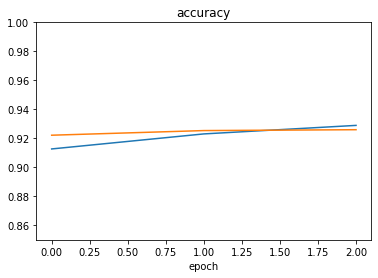

<Figure size 432x288 with 0 Axes>

In [25]:
plot_accuracy(history,miny=0.85)

# CNN1

Convolution layers are generally used to detect patterns in image recognition. We will use the same concept but rather apply it on a sentence instead with the following analogies: 

a kernel size of 3,
64 filters 64 features (values) will be extracted from each position of the kernel,
a ReLU activation.

In [ ]:
n_test = 20000
n_train = 1000000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:n_test+n_train]
y_train = y[n_test:n_test+n_train]

from keras.models import Sequential
model = Sequential()

model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.4))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    epochs=3,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=1)

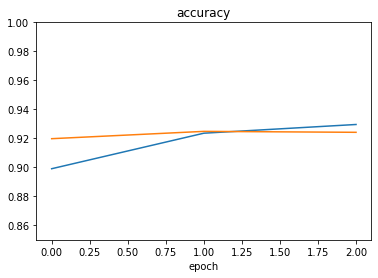

<Figure size 432x288 with 0 Axes>

In [29]:
plot_accuracy(history,miny=0.85)

In [31]:
n_test = 20000
x_test = x[:n_test]
y_test = y[:n_test]
x_train = x[n_test:]
y_train = y[n_test:]

from keras.models import Sequential
model = Sequential()

model.add(keras.layers.Embedding(len(vocab.words), 64, input_length=250))

model.add(keras.layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))

model.add(keras.layers.Dense(100, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=4,
                    batch_size=1000,
                    validation_data=(x_test, y_test),
                    verbose=2)
_____________________________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 64)           1280128   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 250, 16)           3088      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 125, 16)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 125, 32)           1568      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 62, 64)            6208      
_________________________________________________________________
flatten_7 (Flatten)          (None, 3968)              0         
__________

NameError: name '_____________________________' is not defined